In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import datetime as dt
# Classifier Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.metrics import f1_score

### Reading Data

In [2]:
df_train = pd.read_csv("train_data-1599717478076.csv")
df_test=pd.read_csv("test_data-1599717650029.csv")
df_sol=pd.read_csv("solution-by-157-1599727408502-by-212-1632572167611.csv")

In [3]:
df_train.shape,df_test.shape,df_sol.shape

((76529, 11), (19133, 10), (19133, 2))

In [4]:
df_train.head(2)

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud
0,144703125000,17539344,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-5.0,2016-11-15 19:16:12+00:00,2,0
1,77406814453032,24710841,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,100.0,2017-01-11 09:25:33+00:00,2,0


In [5]:
df_test.head(2)

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category
0,857050141038272,3802500,visa_master_debit_cards,118335,cat_1,IND_INR,other_pcs,200.0,2016-12-28 14:44:37+00:00,2
1,4400462872603,200704,e_wallet_payments,23667,cat_2,IND_INR,other_pcs,20.0,2016-12-14 17:49:48+00:00,2


In [6]:
df_train= df_train.drop(['country','partner_id','user_id'],axis=1)
df_test=df_test.drop(['country','user_id','partner_id'],axis=1)

In [7]:
df_sol.head(1)

,transaction_number,is_fraud
0,857050141038272,0


In [8]:
print(df_train.dtypes,'\n',df_test.dtypes)

transaction_number            int64
payment_method               object
partner_category             object
device_type                  object
money_transacted            float64
transaction_initiation       object
partner_pricing_category      int64
is_fraud                      int64
dtype: object 
 transaction_number            int64
payment_method               object
partner_category             object
device_type                  object
money_transacted            float64
transaction_initiation       object
partner_pricing_category      int64
dtype: object


In [9]:
df_train.describe()

,transaction_number,money_transacted,partner_pricing_category,is_fraud
count,7.652900e+04,76529.000000,76529.000000,76529.000000
mean,6.940200e+14,132.724348,2.255707,0.002012
std,7.867885e+14,2350.110900,0.732174,0.044814
min,8.000000e+00,-20000.000000,0.000000,0.000000
25%,4.387866e+13,-1.000000,2.000000,0.000000
50%,3.452540e+14,20.000000,2.000000,0.000000
75%,1.173440e+15,52.000000,2.000000,0.000000
max,2.784238e+15,197217.760000,4.000000,1.000000


In [10]:
df_train.isnull().sum().sum(),df_test.isnull().sum().sum()

(0, 0)

# EDA


In [11]:
## Get the Fraud and the normal dataset 

fraud = df_train[df_train['is_fraud']==1]

normal = df_train[df_train['is_fraud']==0]
# The classes are heavily skewed we need to solve this issue later.

print('No Frauds', round(df_train['is_fraud'].value_counts()[0]/len(df_train) * 100,2), '% of the dataset')
print('Frauds', round(df_train['is_fraud'].value_counts()[1]/len(df_train) * 100,2), '% of the dataset')

No Frauds 99.8 % of the dataset
Frauds 0.2 % of the dataset


#### Note: Notice how imbalanced is our original dataset! Most of the transactions are non-fraud.  If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

In [12]:
df_train[df_train.is_fraud == 1].device_type.value_counts(normalize=True)*100

other_pcs          94.155844
android_devices     3.246753
windows_pcs         2.597403
Name: device_type, dtype: float64

In [13]:
df_train[df_train.is_fraud == 1].payment_method.value_counts(normalize=True)*100

visa_master_credit_cards    34.415584
visa_master_debit_cards     33.116883
other_debit_cards           27.922078
sbi_atm_cum_debit_card       3.246753
e_wallet_payments            1.298701
Name: payment_method, dtype: float64

In [14]:
df_train[df_train.is_fraud == 1].partner_category.value_counts(normalize=True)*100

cat_1    83.116883
cat_2     9.740260
cat_3     5.844156
cat_8     1.298701
Name: partner_category, dtype: float64

In [15]:
df_train.groupby(['payment_method','is_fraud']).mean()


transaction_number  money_transacted  \
payment_method             is_fraud                                         
e_wallet_payments          0               6.999774e+14         73.685087   
                           1               1.552691e+15      11000.000000   
other_debit_cards          0               6.918884e+14        379.458711   
                           1               7.439220e+14      47146.919070   
sbi_atm_cum_debit_card     0               6.907741e+14        -76.264637   
                           1               7.290795e+14      -9604.020000   
unified_payments_interface 0               2.273071e+14         29.200000   
visa_master_credit_cards   0               7.190766e+14        496.783449   
                           1               6.839743e+14      17890.063396   
visa_master_debit_cards    0               6.841605e+14        256.040267   
                           1               7.547601e+14      32708.822353   

                                     partner_pricing_category  
payment_method             is_fraud                            
e_wallet_payments          0                         1.997224  
                           1                         2.000000  
other_debit_cards          0                         2.663971  
                           1                         1.488372  
sbi_atm_cum_debit_card     0                         2.279828  
                           1                         2.800000  
unified_payments_interface 0                         2.000000  
visa_master_credit_cards   0                         1.345689  
                           1                         1.471698  
visa_master_debit_cards    0                         2.842133  
                           1                         2.000000

In [16]:
df_train.groupby(['money_transacted','is_fraud']).mean()

,,transaction_number,partner_pricing_category
money_transacted,is_fraud,,
-20000.00,0,3.689278e+13,4.000000
-18000.00,1,1.847450e+14,4.000000
-10000.00,1,1.030555e+15,2.666667
-4000.00,0,1.120665e+15,4.000000
-3200.00,0,6.548766e+11,4.000000
...,...,...,...
140000.00,1,4.336262e+11,2.000000
172000.00,1,1.749298e+13,2.000000
196000.00,1,9.096842e+14,2.000000


## Graphical visualization 

C:\Users\sa992\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


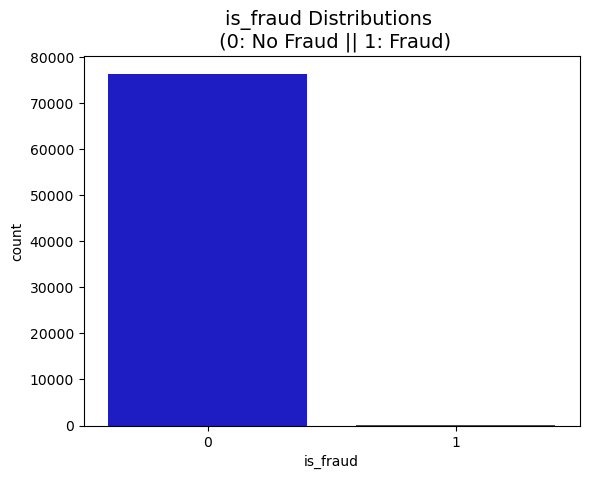

0    76375
1      154
Name: is_fraud, dtype: int64

In [17]:
#3) Graphical Univariate Analysis
#Plot the Distribution
colors = ["#0101DF", "#DF0101"]
sns.countplot('is_fraud', data=df_train, palette=colors)
plt.title('is_fraud Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()
df_train.is_fraud.value_counts()

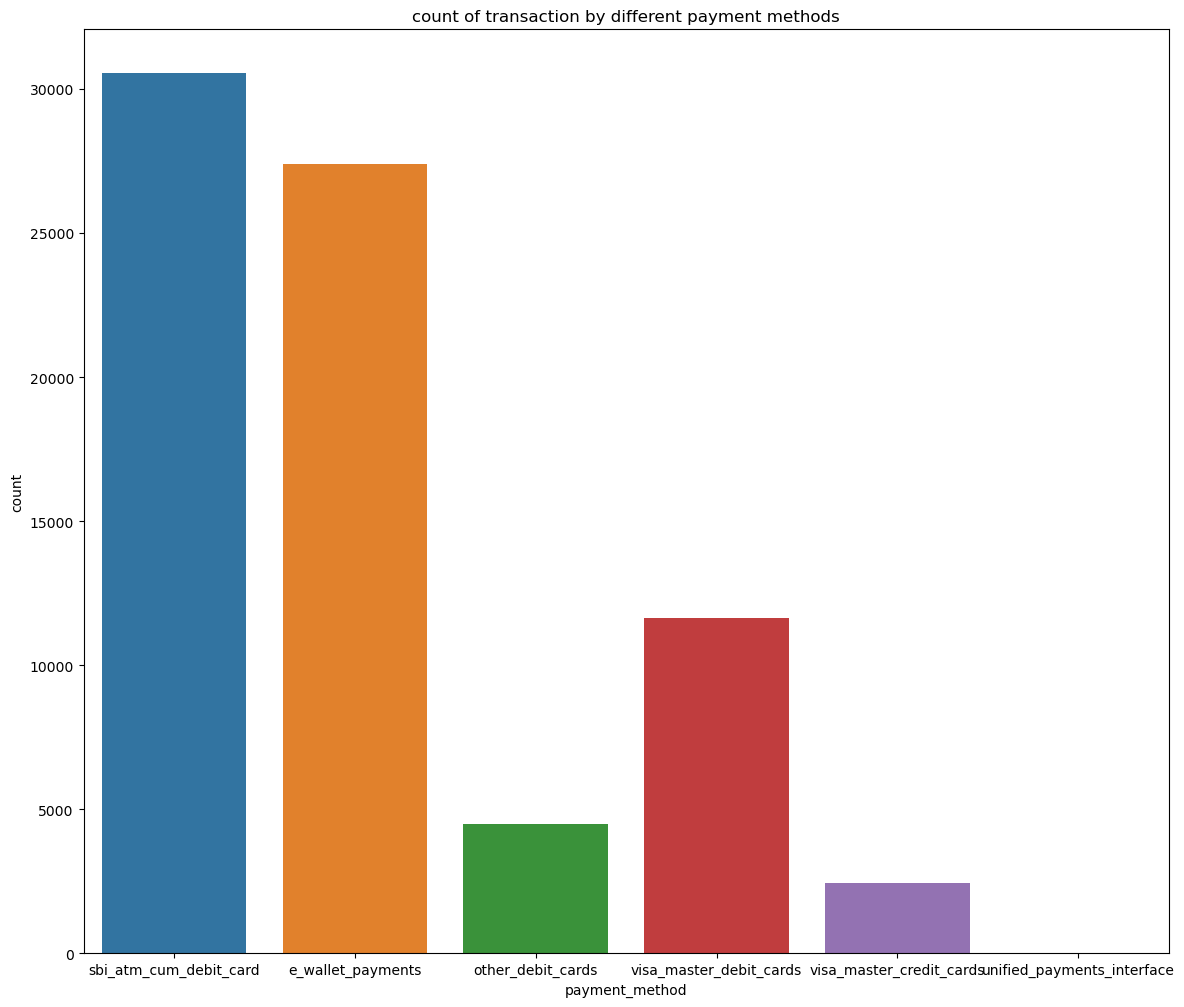

sbi_atm_cum_debit_card        30538
e_wallet_payments             27384
visa_master_debit_cards       11643
other_debit_cards              4495
visa_master_credit_cards       2454
unified_payments_interface       15
Name: payment_method, dtype: int64

In [18]:
plt.figure(figsize=(14,12))
sns.countplot(x="payment_method", data= df_train).set(title='count of transaction by different payment methods')
plt.show()

df_train.payment_method.value_counts()

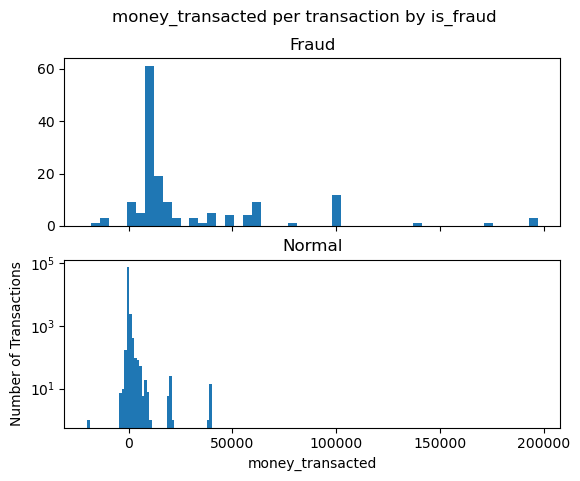

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('money_transacted per transaction by is_fraud')
bins = 50
ax1.hist(fraud.money_transacted, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.money_transacted, bins = bins)
ax2.set_title('Normal')
plt.xlabel('money_transacted')
plt.ylabel('Number of Transactions')
plt.xlim()
plt.yscale('log')
plt.show();

###### So this shows us that fraud occured in all most every range of money transacted and non fraud are only transacte less than 50000 INR. 

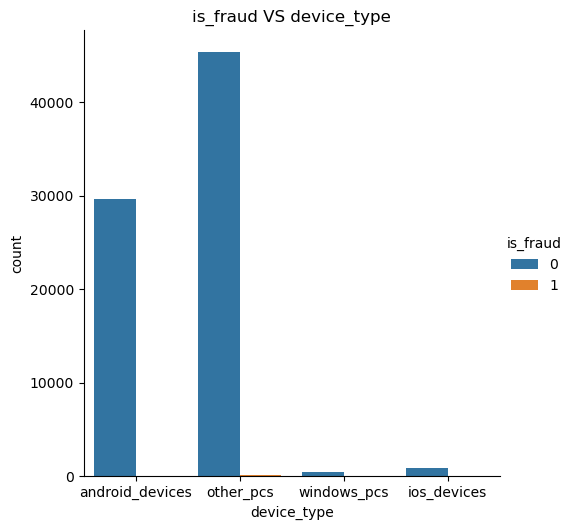

In [20]:
sns.catplot(
    data=df_train,
    x='device_type',
    kind='count',
    hue='is_fraud'
).set(title='is_fraud VS device_type')
plt.show()

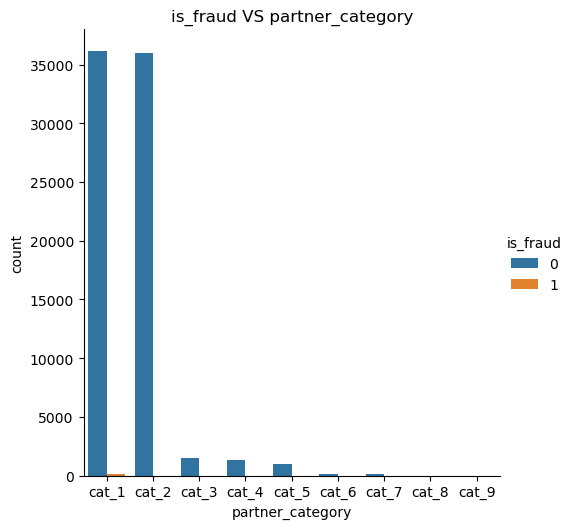

In [21]:
sns.catplot(
    data=df_train,
    x='partner_category',
    kind='count',
    hue='is_fraud'
).set(title='is_fraud VS partner_category')
plt.show()  ##Most of the fraud are occuring in partner_category 1.

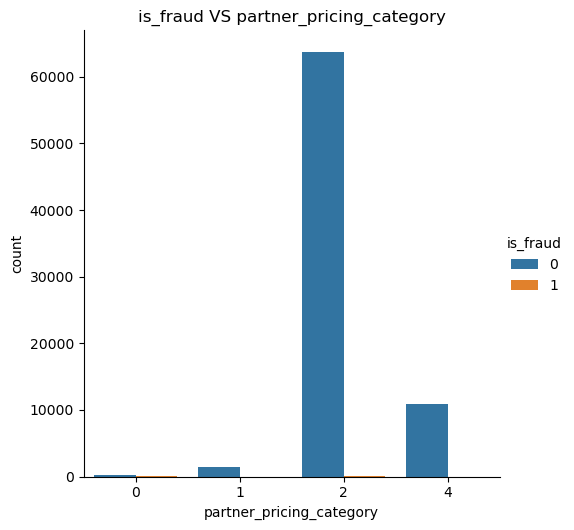

In [22]:
sns.catplot(
    data=df_train,
    x='partner_pricing_category',
    kind='count',
    hue='is_fraud'
).set(title='is_fraud VS partner_pricing_category')
plt.show() ## Most of the fraud occuring according to partner_pricing_category are lies in 0.

##### Performed some data mining and feature engeering and formed some new features for more understanding of data.

In [23]:
df_train['transaction_initiation'] = pd.to_datetime(df_train['transaction_initiation'], format='%Y-%m-%d %H:%M:%S.%f', utc=True)
df_test['transaction_initiation'] = pd.to_datetime(df_test['transaction_initiation'], format='%Y-%m-%d %H:%M:%S.%f', utc=True)

In [24]:
df_test['day_of_transaction'] = df_test['transaction_initiation'].dt.strftime('%A')
df_train['day_of_transaction'] = df_train['transaction_initiation'].dt.strftime('%A')

df_train['transaction_time'] = df_train['transaction_initiation'].dt.strftime('%H')
df_test['transaction_time'] = df_test['transaction_initiation'].dt.strftime('%H')

df_train['transaction_mon'] = df_train['transaction_initiation'].dt.strftime('%m')
df_test['transaction_mon'] = df_test['transaction_initiation'].dt.strftime('%m')

df_train['transaction_year'] = df_train['transaction_initiation'].dt.strftime('%d-%m-%Y')
df_test['transaction_year'] = df_test['transaction_initiation'].dt.strftime('%d-%m-%Y')

df_train['transaction_initiation'] = pd.to_datetime(df_train['transaction_initiation'])
df_train['transaction_initiation']=df_train['transaction_initiation'].map(dt.datetime.toordinal)

df_test['transaction_initiation'] = pd.to_datetime(df_test['transaction_initiation'])
df_test['transaction_initiation']=df_test['transaction_initiation'].map(dt.datetime.toordinal)

In [25]:
def get_part_of_day(h):
    return (
        "morning"
        if 4 <= h <= 11
        else "afternoon"
        if 12 <= h <= 17
        else "evening"
        if 18 <= h <= 20
        else "night"
    )

In [26]:
df_train['transaction_time'] = df_train['transaction_time'].apply(int)
df_test['transaction_time'] = df_test['transaction_time'].apply(int)

In [27]:
df_train['transaction_time'] = df_train['transaction_time'].apply(get_part_of_day)
df_test['transaction_time'] = df_test['transaction_time'].apply(get_part_of_day)

In [28]:

df_train

,transaction_number,payment_method,partner_category,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud,day_of_transaction,transaction_time,transaction_mon,transaction_year
0,144703125000,sbi_atm_cum_debit_card,cat_1,android_devices,-5.0,736283,2,0,Tuesday,evening,11,15-11-2016
1,77406814453032,e_wallet_payments,cat_2,other_pcs,100.0,736340,2,0,Wednesday,morning,01,11-01-2017
2,308929485482801,e_wallet_payments,cat_2,other_pcs,50.0,736305,2,0,Wednesday,morning,12,07-12-2016
3,665270027747073,other_debit_cards,cat_3,other_pcs,1000.0,736340,2,0,Wednesday,afternoon,01,11-01-2017
4,38276160171101,other_debit_cards,cat_1,other_pcs,200.0,736284,2,0,Wednesday,afternoon,11,16-11-2016
...,...,...,...,...,...,...,...,...,...,...,...,...
76524,179759462245453,sbi_atm_cum_debit_card,cat_1,android_devices,-100.0,736298,2,0,Wednesday,afternoon,11,30-11-2016
76525,2693567760244353,visa_master_debit_cards,cat_1,other_pcs,200.0,736337,2,0,Sunday,morning,01,08-01-2017
76526,119750257089000,sbi_atm_cum_debit_card,cat_1,android_devices,-3.5,736324,2,0,Monday,night,12,26-12-2016
76527,1949798765017089,sbi_atm_cum_debit_card,cat_1,android_devices,-20.0,736309,2,0,Sunday,afternoon,12,11-12-2016


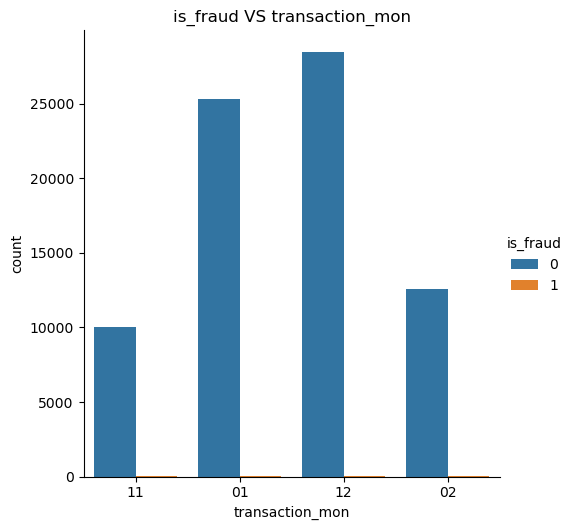

In [29]:
sns.catplot(
    data=df_train,
    x='transaction_mon',
    kind='count',
    hue='is_fraud'
).set(title='is_fraud VS transaction_mon')
plt.show()

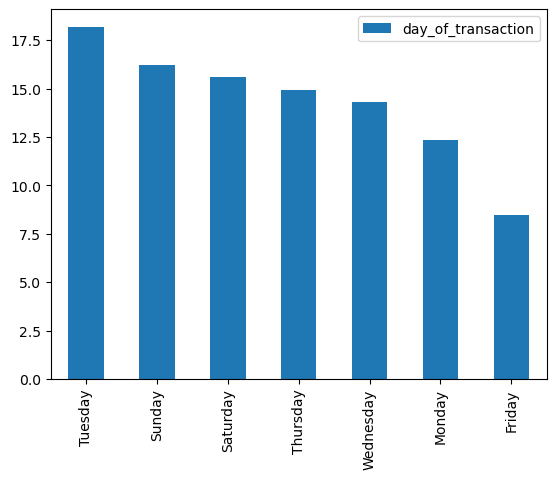

Tuesday      18.181818
Sunday       16.233766
Saturday     15.584416
Thursday     14.935065
Wednesday    14.285714
Monday       12.337662
Friday        8.441558
Name: day_of_transaction, dtype: float64

In [30]:
trnscDay_df = pd.DataFrame(df_train[df_train.is_fraud == 1].day_of_transaction.value_counts(normalize=True)*100)
trnscDay_df.plot(kind = 'bar')
plt.show()
df_train[df_train.is_fraud == 1].day_of_transaction.value_counts(normalize=True)*100

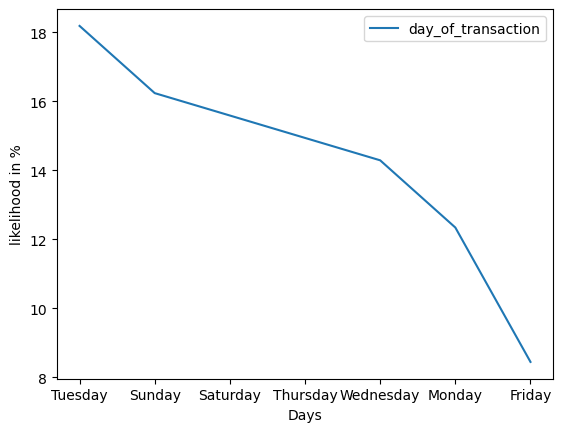

In [31]:
ax = sns.lineplot(data=trnscDay_df )
ax.set(xlabel = 'Days', ylabel = 'likelihood in %')
plt.show()## Weekends and tuesday having more fraud cases.

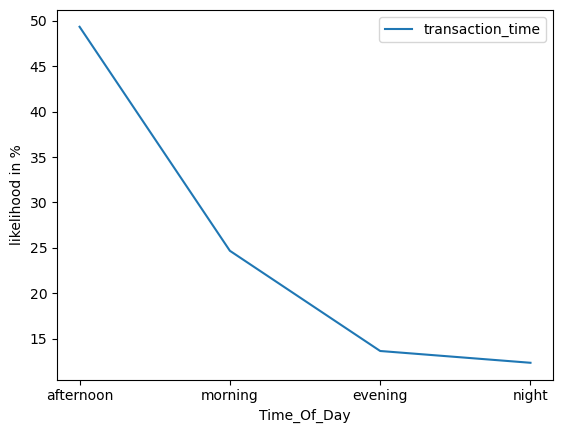

afternoon    49.350649
morning      24.675325
evening      13.636364
night        12.337662
Name: transaction_time, dtype: float64

In [32]:
trnsc_time_df = pd.DataFrame(df_train[df_train.is_fraud == 1].transaction_time.value_counts(normalize=True)*100)


ax = sns.lineplot(data=trnsc_time_df )
ax.set(xlabel = 'Time_Of_Day', ylabel = 'likelihood in %')
plt.show()

df_train[df_train.is_fraud == 1].transaction_time.value_counts(normalize=True)*100 ## so most of the frauds are occuring in morning and afternoon time.

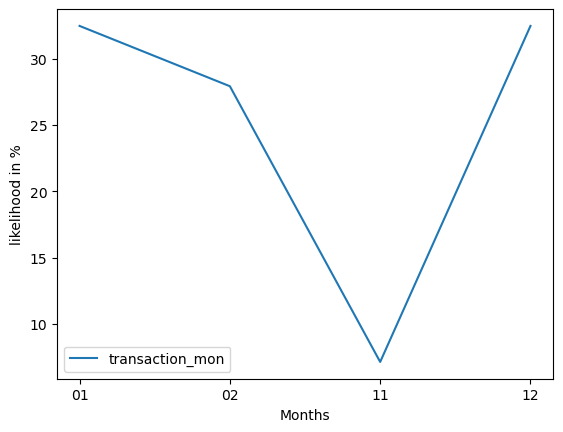

01    32.467532
12    32.467532
02    27.922078
11     7.142857
Name: transaction_mon, dtype: float64

In [33]:
trnsc_mon_df = pd.DataFrame(df_train[df_train.is_fraud == 1].transaction_mon.value_counts(normalize=True)*100)
trnsc_mon_df['mon'] = trnsc_mon_df.index
ax = sns.lineplot(data=trnsc_mon_df.sort_values(by ='mon',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last') )
ax.set(xlabel = 'Months', ylabel = 'likelihood in %')
plt.show()

df_train[df_train.is_fraud == 1].transaction_mon.value_counts(normalize=True)*100

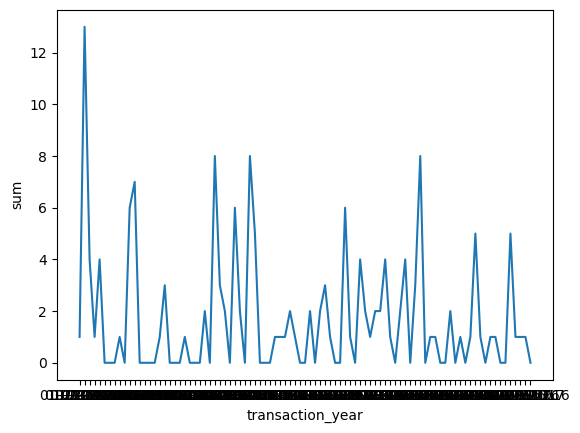

In [34]:
counts=df_train["is_fraud"].groupby(df_train['transaction_year']).aggregate(["sum"])
counts
sns.lineplot(data=counts.sort_values(by ='transaction_year',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last'), x="transaction_year", y="sum")
plt.show()

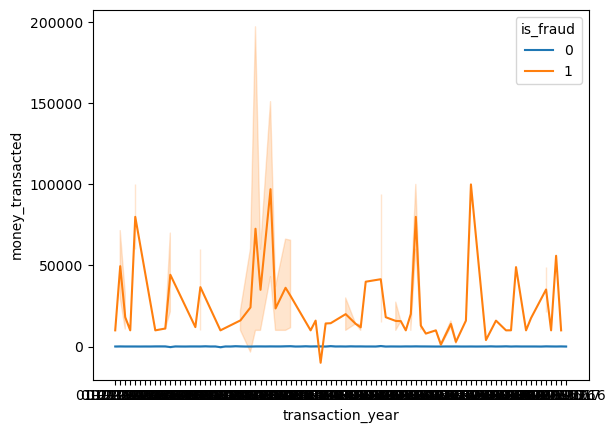

In [35]:
sns.lineplot(data=df_train.sort_values(by ='transaction_year',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last'), x="transaction_year", y="money_transacted", hue="is_fraud")
plt.show()

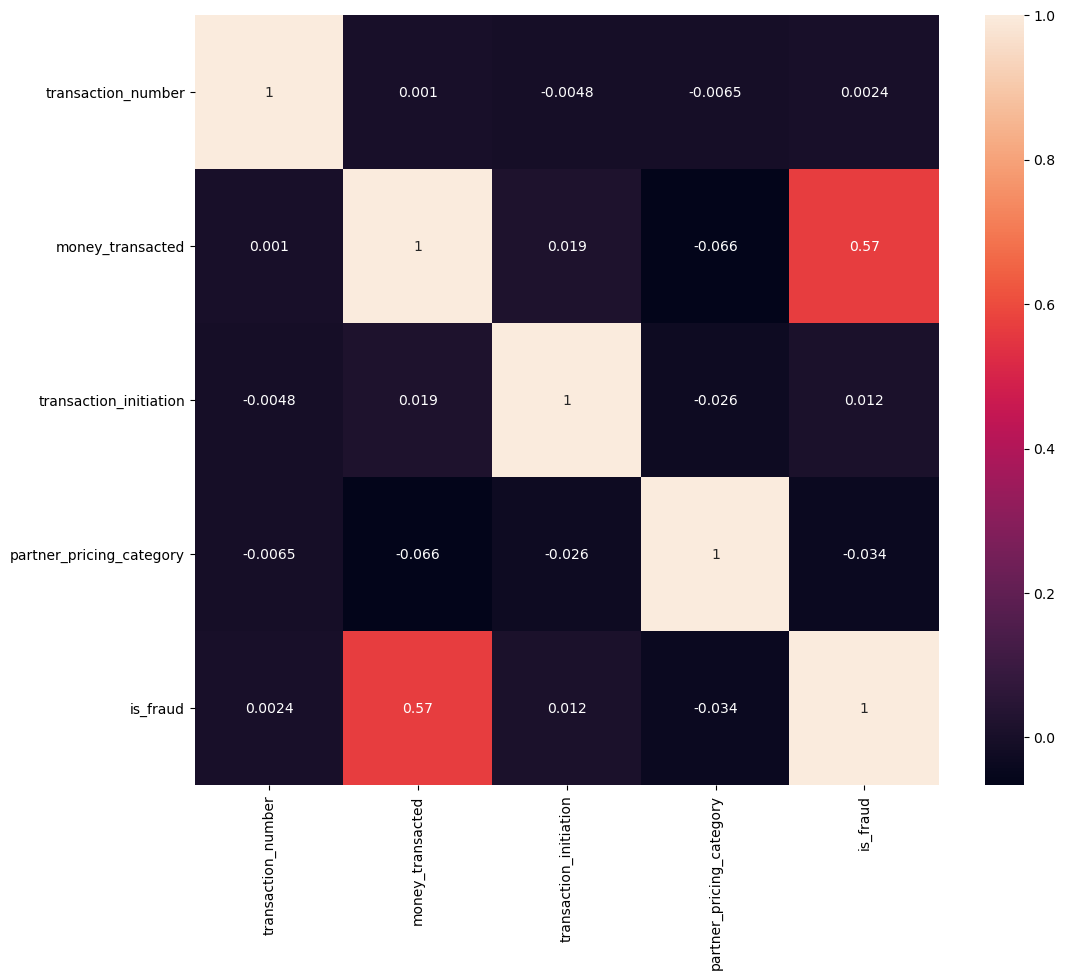

In [36]:
categorical_columns = [cname for cname in df_train.columns if df_train[cname].dtype == 'object']

numerical_columns   = [cname for cname in df_train.columns if df_train[cname].dtype in['int64', 'float64']]
plt.figure(figsize=(12,10))
data = df_train[numerical_columns]

df = pd.DataFrame(data)

corrMatrix = df.corr(method = 'pearson',min_periods = 1)
sns.heatmap(corrMatrix, annot=True)
plt.show()

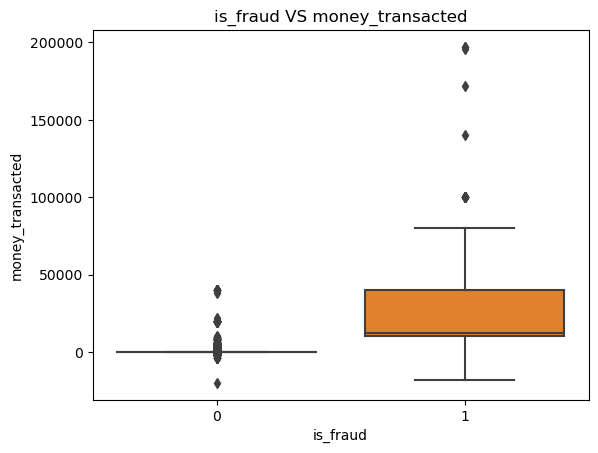

In [37]:
sns.boxplot(x="is_fraud",y="money_transacted",data=df_train).set(title='is_fraud VS money_transacted')
plt.show() 
## more amount of money are transacted by frauds as compared to Non fraud users.

In [38]:
df_train

,transaction_number,payment_method,partner_category,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud,day_of_transaction,transaction_time,transaction_mon,transaction_year
0,144703125000,sbi_atm_cum_debit_card,cat_1,android_devices,-5.0,736283,2,0,Tuesday,evening,11,15-11-2016
1,77406814453032,e_wallet_payments,cat_2,other_pcs,100.0,736340,2,0,Wednesday,morning,01,11-01-2017
2,308929485482801,e_wallet_payments,cat_2,other_pcs,50.0,736305,2,0,Wednesday,morning,12,07-12-2016
3,665270027747073,other_debit_cards,cat_3,other_pcs,1000.0,736340,2,0,Wednesday,afternoon,01,11-01-2017
4,38276160171101,other_debit_cards,cat_1,other_pcs,200.0,736284,2,0,Wednesday,afternoon,11,16-11-2016
...,...,...,...,...,...,...,...,...,...,...,...,...
76524,179759462245453,sbi_atm_cum_debit_card,cat_1,android_devices,-100.0,736298,2,0,Wednesday,afternoon,11,30-11-2016
76525,2693567760244353,visa_master_debit_cards,cat_1,other_pcs,200.0,736337,2,0,Sunday,morning,01,08-01-2017
76526,119750257089000,sbi_atm_cum_debit_card,cat_1,android_devices,-3.5,736324,2,0,Monday,night,12,26-12-2016
76527,1949798765017089,sbi_atm_cum_debit_card,cat_1,android_devices,-20.0,736309,2,0,Sunday,afternoon,12,11-12-2016


#### Labelencoding 

In [39]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train["payment_method"]=le.fit_transform(df_train["payment_method"])
df_train["partner_category"]=le.fit_transform(df_train["partner_category"])
df_train["device_type"]=le.fit_transform(df_train["device_type"])
df_train["partner_pricing_category"]=le.fit_transform(df_train["partner_pricing_category"])
df_train["day_of_transaction"]=le.fit_transform(df_train["day_of_transaction"])
df_train["transaction_time"]=le.fit_transform(df_train["transaction_time"])
df_train["transaction_year"]=le.fit_transform(df_train["transaction_year"])

df_test["payment_method"]=le.fit_transform(df_test["payment_method"])
df_test["partner_category"]=le.fit_transform(df_test["partner_category"])
df_test["device_type"]=le.fit_transform(df_test["device_type"])
df_test["partner_pricing_category"]=le.fit_transform(df_test["partner_pricing_category"])
df_test["day_of_transaction"]=le.fit_transform(df_test["day_of_transaction"])
df_test["transaction_time"]=le.fit_transform(df_test["transaction_time"])
df_test["transaction_year"]=le.fit_transform(df_test["transaction_year"])

### Spliting data

In [40]:
x_train = df_train.drop(['is_fraud',"transaction_number"], axis = 1)
y_train = df_train['is_fraud']
x_test = df_test.drop("transaction_number", axis = 1)
y_test=df_sol['is_fraud']

### Models

####  LogisticRegression

In [41]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,y_train)
predict = lr.predict(x_test)
df = pd.DataFrame({"transaction_number":df_test['transaction_number'],"is_fraud":predict}, columns=["transaction_number","is_fraud"])
print(df.is_fraud.value_counts())
print("n")
from sklearn.metrics import f1_score
print("F1 Score: ",f1_score(df_sol['is_fraud'],df['is_fraud']))
print(df_sol.is_fraud.value_counts())

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  predict)
print("confusion_matrix_test",confusion_matrix_test)

0    19112
1       21
Name: is_fraud, dtype: int64
n
F1 Score:  0.43333333333333335
0    19094
1       39
Name: is_fraud, dtype: int64
confusion_matrix_test [[19086     8]
 [   26    13]]


#### DecisionTree

In [42]:
from sklearn import tree
model=tree.DecisionTreeClassifier()
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
print(model.score(x_train,y_train))
df_dt = pd.DataFrame({"transaction_number":df_test['transaction_number'],"is_fraud":y_test_pred}, columns=["transaction_number","is_fraud"])
print(df_dt.is_fraud.value_counts())
print("F1 Score: ",f1_score(df_sol['is_fraud'],df_dt['is_fraud']))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  y_test_pred)
print("confusion_matrix_test",confusion_matrix_test)

0.9999085314063949
0    19095
1       38
Name: is_fraud, dtype: int64
F1 Score:  0.8311688311688312
confusion_matrix_test [[19088     6]
 [    7    32]]


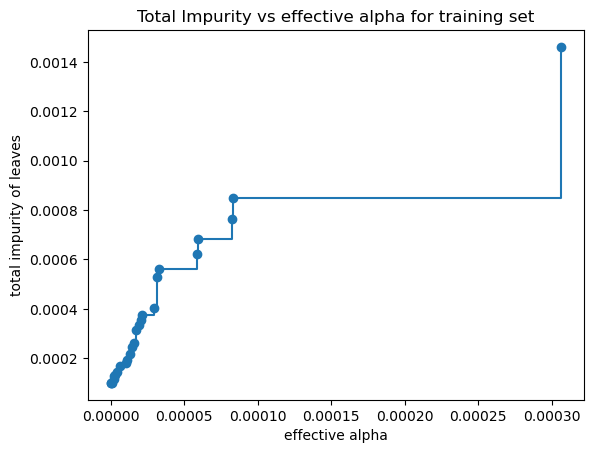

f1_score 0.8611111111111112
classification_report on train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76375
           1       0.99      0.92      0.96       154

    accuracy                           1.00     76529
   macro avg       1.00      0.96      0.98     76529
weighted avg       1.00      1.00      1.00     76529

classification_report on test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19094
           1       0.94      0.79      0.86        39

    accuracy                           1.00     19133
   macro avg       0.97      0.90      0.93     19133
weighted avg       1.00      1.00      1.00     19133



In [43]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = 7777)
dt.fit(x_train, y_train)
path = dt.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

Dt = DecisionTreeClassifier(ccp_alpha=0.000015)
decision_tree = Dt.fit(x_train, y_train)

y_train_pred = decision_tree.predict(x_train)
y_test_pred = decision_tree.predict(x_test)
print("f1_score",f1_score(y_test, y_test_pred))

from sklearn.metrics import classification_report
print("classification_report on train")
print(classification_report(y_train, y_train_pred))
print("classification_report on test")
print(classification_report(y_test, y_test_pred))

### KNeighborsClassifier

In [44]:
## KNeighbors model
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
knn_prediction=knn.predict(x_test)
df_knn = pd.DataFrame({"transaction_number":df_test['transaction_number'],"is_fraud":knn_prediction}, columns=["transaction_number","is_fraud"])
print(df_knn.is_fraud.value_counts())
print("F1 Score: ",f1_score(df_sol['is_fraud'],df_knn['is_fraud']))

confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  knn_prediction)
print("confusion_matrix_test",confusion_matrix_test)


0    19098
1       35
Name: is_fraud, dtype: int64
F1 Score:  0.8918918918918919
confusion_matrix_test [[19092     2]
 [    6    33]]


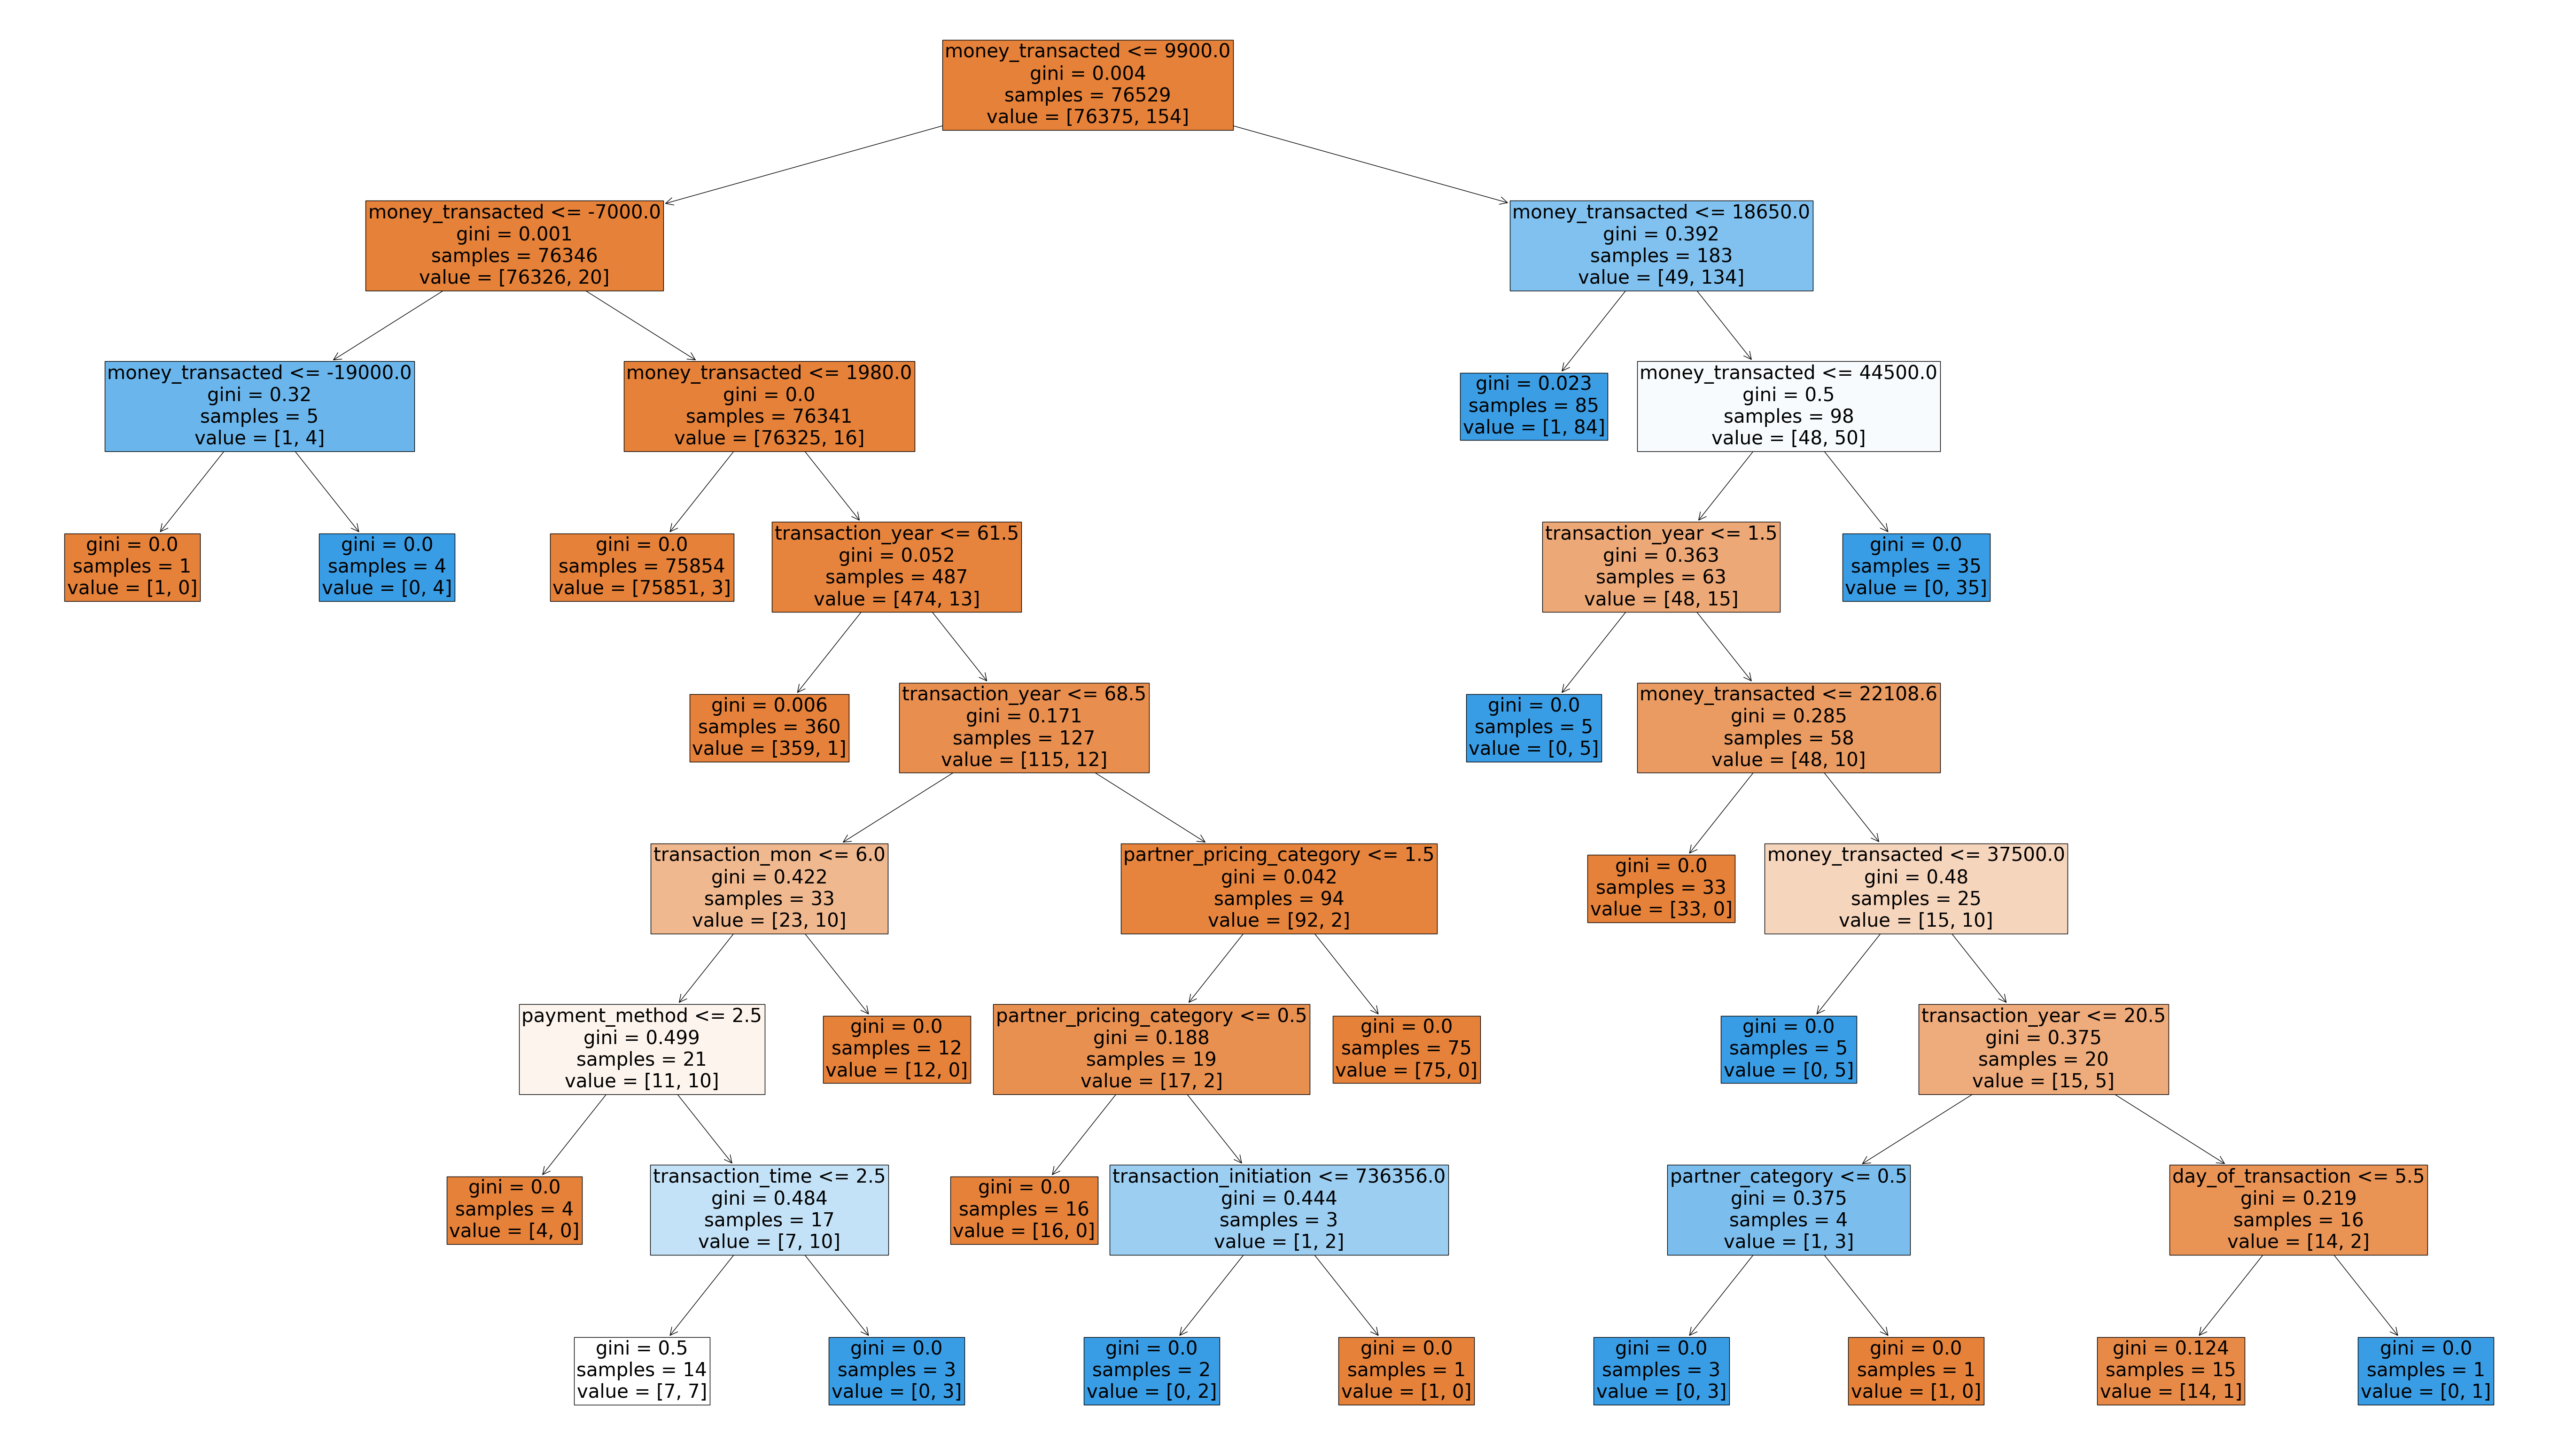

In [45]:
from sklearn import tree
plt.figure(figsize =(70,40))
tree.plot_tree(decision_tree, feature_names=x_train.columns,filled=True,fontsize = 29)
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix
print("Final Matrix")
pd.DataFrame(confusion_matrix(df_sol['is_fraud'], knn_prediction), columns=['Predicted No','Predicted Yes'], index=['Actual No','Actual Yes'])

Final Matrix


,Predicted No,Predicted Yes
Actual No,19092,2
Actual Yes,6,33


##### Grid search --> for more confirms on our models

In [ ]:
# Grid search cross validation
param_grid = {'C': [0.1,0.5,1,10], 'max_iter' : [500, 750], 'tol':[0.00001,0.0001, 0.001]}
lr_grid = GridSearchCV(LogisticRegression(solver = 'liblinear'),param_grid, cv=5)
lr_grid.fit(x_train, y_train)
print(lr_grid.best_score_)    
print(lr_grid.best_params_)
print(lr_grid.best_estimator_)

In [ ]:
lr_model = LogisticRegression(C=0.1, max_iter=500, solver='liblinear', tol=1e-05)
lr_model.fit(x_train, y_train)
lr_yhat = lr_model.predict(x_test)
df = pd.DataFrame({"transaction_number":df_test['transaction_number'],"is_fraud":lr_yhat}, columns=["transaction_number","is_fraud"])
print(df.is_fraud.value_counts())
from sklearn.metrics import f1_score
print("F1 Score: ",f1_score(df_sol['is_fraud'],df['is_fraud']))
print(df_sol.is_fraud.value_counts())

In [ ]:
param_grid = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn_grid.fit(x_train, y_train)

print(knn_grid.best_score_)    
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train, y_train)
knn_yhat = knn_model.predict(x_test)
df_knn = pd.DataFrame({"transaction_number":df_test['transaction_number'],"is_fraud":knn_yhat}, columns=["transaction_number","is_fraud"])
print(df_knn.is_fraud.value_counts())
print("F1 Score: ",f1_score(df_sol['is_fraud'],df_knn['is_fraud']))
confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  knn_yhat)
print("confusion_matrix_test",confusion_matrix_test)

In [47]:
Dt.feature_importances_

array([0.00776625, 0.00519853, 0.        , 0.90209336, 0.00462092,
       0.00894689, 0.00566063, 0.00428115, 0.01200239, 0.04942989])

In [48]:
x_train=x_train.drop('transaction_mon',axis=1)
x_test=x_test.drop('transaction_mon',axis=1)

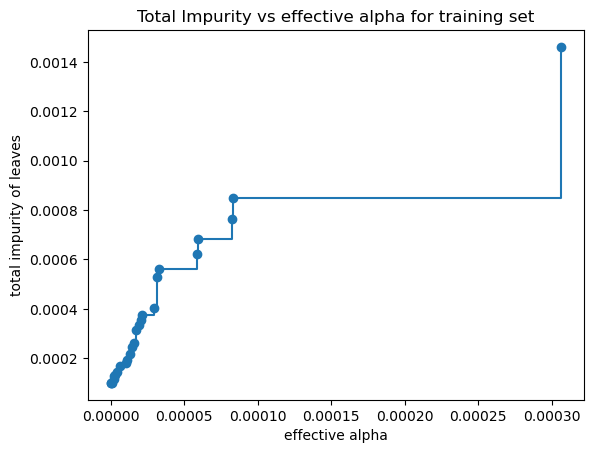

f1_score 0.8767123287671232
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76375
           1       0.97      0.97      0.97       154

    accuracy                           1.00     76529
   macro avg       0.99      0.99      0.99     76529
weighted avg       1.00      1.00      1.00     76529

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19094
           1       0.94      0.82      0.88        39

    accuracy                           1.00     19133
   macro avg       0.97      0.91      0.94     19133
weighted avg       1.00      1.00      1.00     19133



In [49]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = 7777)
dt.fit(x_train, y_train)
path = dt.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

Dt = DecisionTreeClassifier(ccp_alpha=0.00001)
decision_tree = Dt.fit(x_train, y_train)

y_train_pred = decision_tree.predict(x_train)
y_test_pred = decision_tree.predict(x_test)
print("f1_score",f1_score(y_test, y_test_pred))

from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

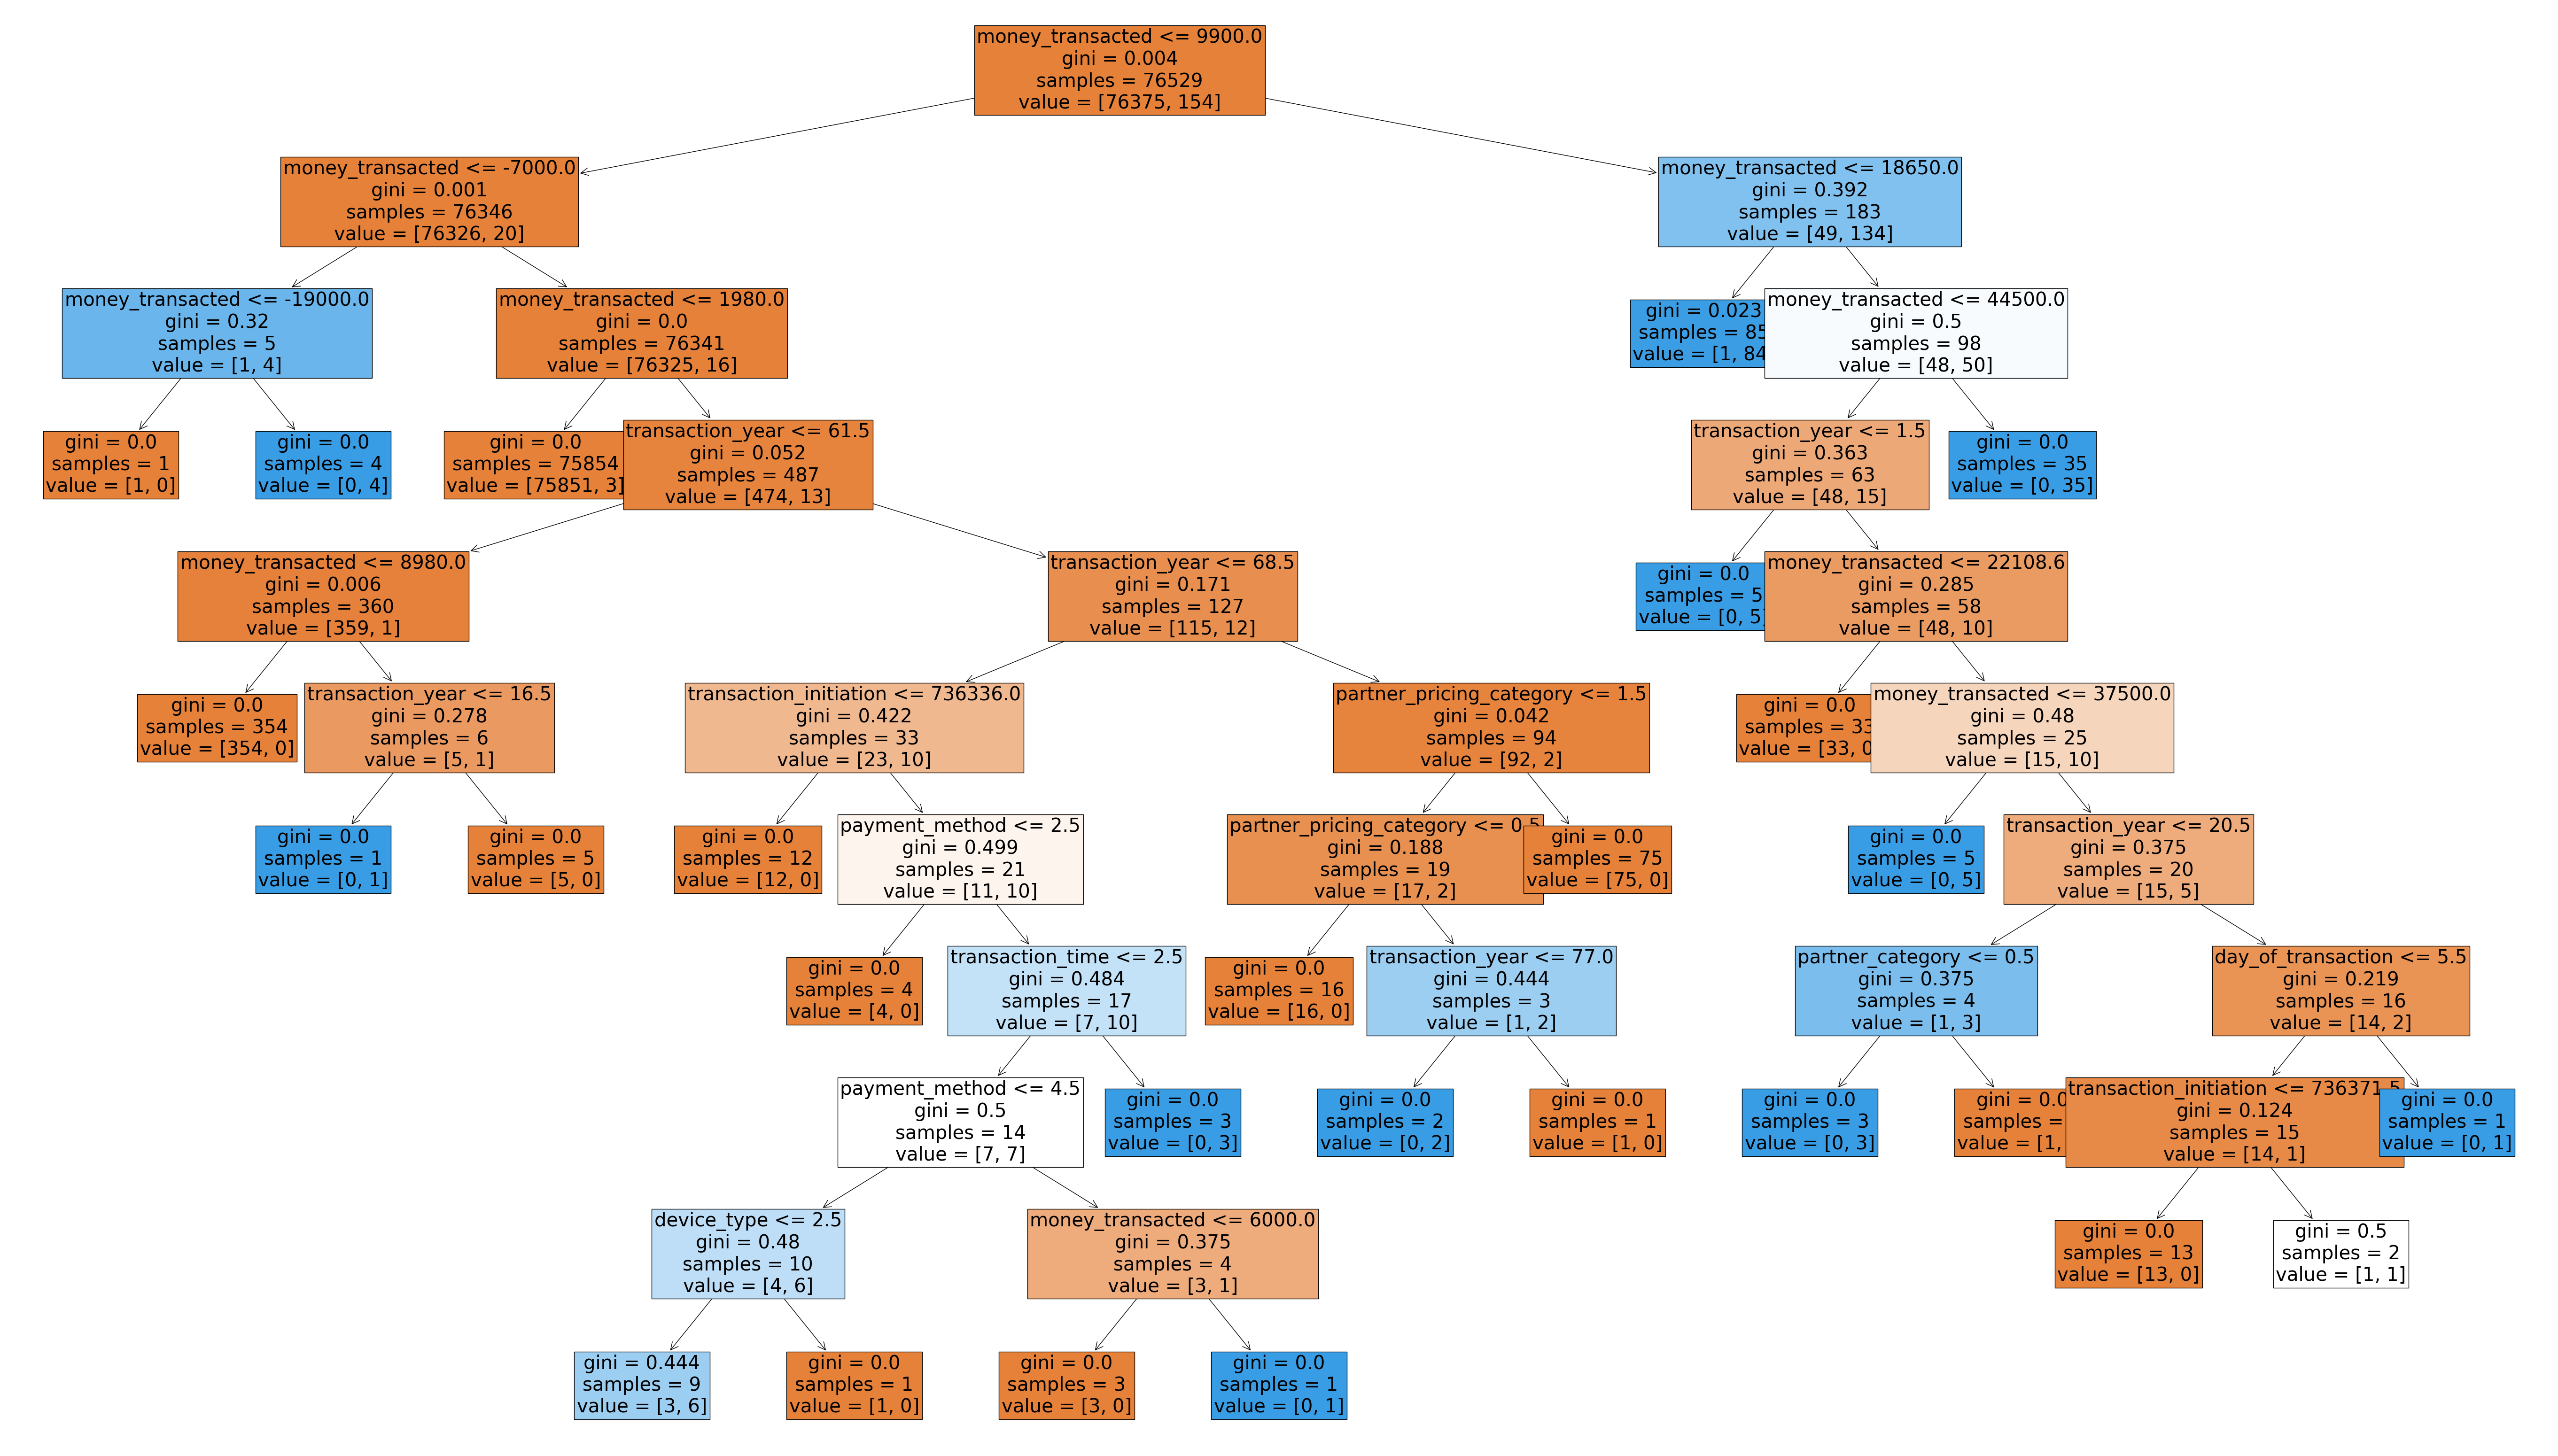

In [50]:
from sklearn import tree
plt.figure(figsize =(70,40))
tree.plot_tree(decision_tree, feature_names=x_train.columns,filled=True,fontsize = 29)
plt.show()

### Conclusion: 
####  Recommendations to IndAvenue
* Have a double check whenever there is a transcation of large amount.
* Most of the frauds are done by user who uses device type Other_pcs for transaction.So IndAvenue system not run on other_pcs.
* Most of the frauds are occuring in morning and afternoon time.
* Most of the fraud are occuring by user who lies partner in partner_category 1. so must check with partner category 1 to ensure safe transaction.
* In 2nd month(feb) Large amount of money was transacted by user who did fraud. 
* Avoid the use of Visa master debit card by user to decrease the rate of occuring frauds
* To ensure fastcustomer checkout SBI debit card and E_wallets paymemts are safest option for coustmer and IndAvenue. so enchourage coustmer to use them.


* Keep an eye out for big-dollar transactions because those are where fraud happens most frequently. We can see that the afternoon and morning hours are when the majority of fraud transactions take place. The device from which payments are made needs to be examined because most fraud cases are visible on other pcs.
* There are very few instances of fraud involving smaller sums, between zero and five thousand rupees. Although Visa master credit and debit cards are more prone to experience fraud, other debit cards should also be taken into consideration. The volume of transactions done by a single user can also be used to infer information about the likelihood of fraud.

* ML model explained
* ML model I use is a classifier model.
* It categorises each row of data according to its conditions.
* The model first determines from the data what are the circumstances that lead to fraud cases.
* It classifies each new row of provided data and keeps track of the patterns of circumstances.
* kNN stands for k-Nearest Neighbours. It is a supervised learning algorithm. This means that we train it under supervision. We * train it using the labelled data already available to us.
 Stratergies FastCustomer Checkout :
* The organisation should use quick, responsive servers, and local servers should also be well-maintained for emergencies.
* As it is crucial for fraud scenarios, the payment gateaway server shouldn't permit transactions from other OS PCs.
* The e wallet payment option should be recommended more in order to decrease fraud, as it is well developed in terms of bank authorizations as well.
* There shouldn't be any redirects to other websites, as this could cause errors or connectivity problems on the website or with the bank.
* To enable quick and secure transactions, the customer's internet bandwidth should be above a specific threshold.

In [ ]:
### final visualization

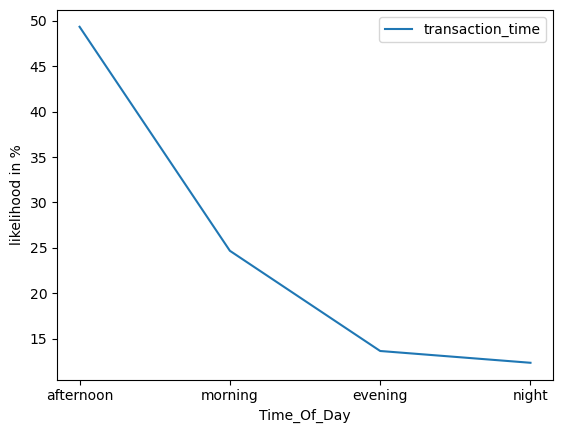

afternoon    49.350649
morning      24.675325
evening      13.636364
night        12.337662
Name: transaction_time, dtype: float64

In [32]:
trnsc_time_df = pd.DataFrame(df_train[df_train.is_fraud == 1].transaction_time.value_counts(normalize=True)*100)


ax = sns.lineplot(data=trnsc_time_df )
ax.set(xlabel = 'Time_Of_Day', ylabel = 'likelihood in %')
plt.show()

df_train[df_train.is_fraud == 1].transaction_time.value_counts(normalize=True)*100 ## so most of the frauds are occuring in morning and afternoon time.

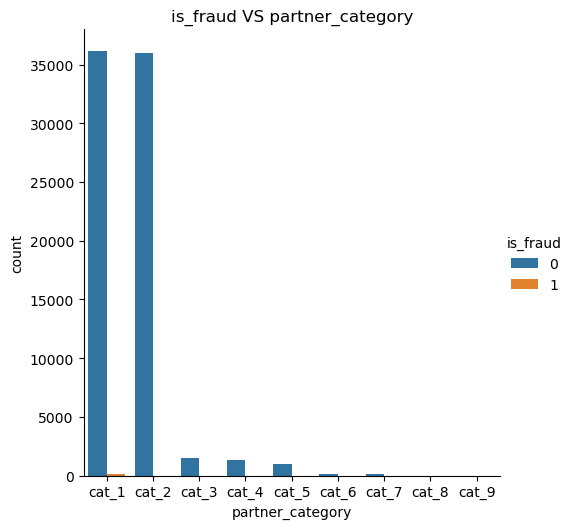

In [21]:
sns.catplot(
    data=df_train,
    x='partner_category',
    kind='count',
    hue='is_fraud'
).set(title='is_fraud VS partner_category')
plt.show()  ##Most of the fraud are occuring in partner_category 1.